In [1]:

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
import joblib


In [2]:
df = pd.read_csv(
    "cleaned_energy_data.csv",
    parse_dates=True,
    index_col=0
)

df.head()


,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
DateTime,,,,,,,
2006-12-16 17:24:00,4.216,0.418,234.84,18.4,0.0,1.0,17.0
2006-12-16 17:25:00,5.360,0.436,233.63,23.0,0.0,1.0,16.0
2006-12-16 17:26:00,5.374,0.498,233.29,23.0,0.0,2.0,17.0
2006-12-16 17:27:00,5.388,0.502,233.74,23.0,0.0,1.0,17.0
2006-12-16 17:28:00,3.666,0.528,235.68,15.8,0.0,1.0,17.0


In [3]:
target_col = "Global_active_power"
data = df[[target_col]]


In [4]:
scaler = MinMaxScaler()
scaled_values = scaler.fit_transform(data)

scaled_values[:5]


array([[0.37479631],
       [0.47836321],
       [0.47963064],
       [0.48089806],
       [0.32500453]])

In [5]:
def create_sequences(data, window_size):
    X, y = [], []
    for i in range(window_size, len(data)):
        X.append(data[i-window_size:i])
        y.append(data[i])
    return np.array(X), np.array(y)


WINDOW_SIZE = 24
X, y = create_sequences(scaled_values, WINDOW_SIZE)

X.shape, y.shape


((2075235, 24, 1), (2075235, 1))

In [6]:
split_ratio = 0.8
split_idx = int(len(X) * split_ratio)

X_train, X_test = X[:split_idx], X[split_idx:]
y_train, y_test = y[:split_idx], y[split_idx:]


In [7]:
model = Sequential()

model.add(
    LSTM(
        units=64,
        return_sequences=True,
        input_shape=(X_train.shape[1], 1)
    )
)
model.add(Dropout(0.2))

model.add(LSTM(units=32))
model.add(Dropout(0.2))

model.add(Dense(1))

optimizer = Adam(learning_rate=0.001)

model.compile(
    optimizer=optimizer,
    loss="mse"
)

model.summary()


C:\Users\vinay\AppData\Roaming\Python\Python313\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 24, 64)         │        16,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 24, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 32)             │        12,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 29,345 (114.63 KB)

 Trainable params: 29,345 (114.63 KB)

 Non-trainable params: 0 (0.00 B)

In [8]:
early_stop = EarlyStopping(
    monitor="val_loss",
    patience=5,
    restore_best_weights=True
)


In [20]:
history = model.fit(
    X_train,
    y_train,
    epochs=30,
    batch_size=64,
    validation_split=0.1,
    callbacks=[early_stop],
    verbose=1
)


Epoch 1/30
23259/23347 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 7.2562e-04

KeyboardInterrupt: 

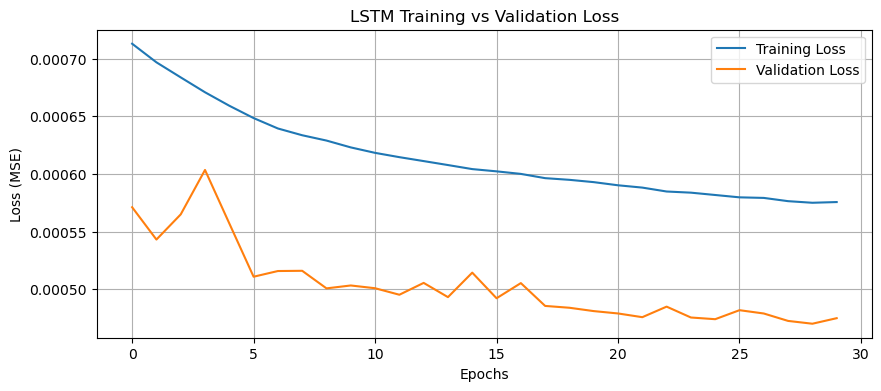

In [ ]:
plt.figure(figsize=(10,4))
plt.plot(history.history["loss"], label="Training Loss")
plt.plot(history.history["val_loss"], label="Validation Loss")
plt.title("LSTM Training vs Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss (MSE)")
plt.legend()
plt.grid(True)
plt.show()


In [14]:
y_pred_scaled = model.predict(X_test)

y_pred = scaler.inverse_transform(y_pred_scaled)
y_test_actual = scaler.inverse_transform(y_test)


12971/12971 ━━━━━━━━━━━━━━━━━━━━ 46s 3ms/step


In [15]:
mae = mean_absolute_error(y_test_actual, y_pred)
rmse = np.sqrt(mean_squared_error(y_test_actual, y_pred))
r2 = r2_score(y_test_actual, y_pred)

print(f"MAE : {mae:.3f}")
print(f"RMSE: {rmse:.3f}")
print(f"R²  : {r2:.3f}")


MAE : 0.102
RMSE: 0.226
R²  : 0.934


In [ ]:
baseline_mae = 0.45    
baseline_rmse = 0.62
baseline_r2 = 0.71


In [17]:
lstm_mae = mae
lstm_rmse = rmse
lstm_r2 = r2


In [18]:
comparison_df = pd.DataFrame({
    "Model": ["Linear Regression", "LSTM"],
    "MAE": [baseline_mae, lstm_mae],
    "RMSE": [baseline_rmse, lstm_rmse],
    "R2 Score": [baseline_r2, lstm_r2]
})

comparison_df


,Model,MAE,RMSE,R2 Score
0,Linear Regression,0.450000,0.620000,0.710000
1,LSTM,0.101943,0.225534,0.934144


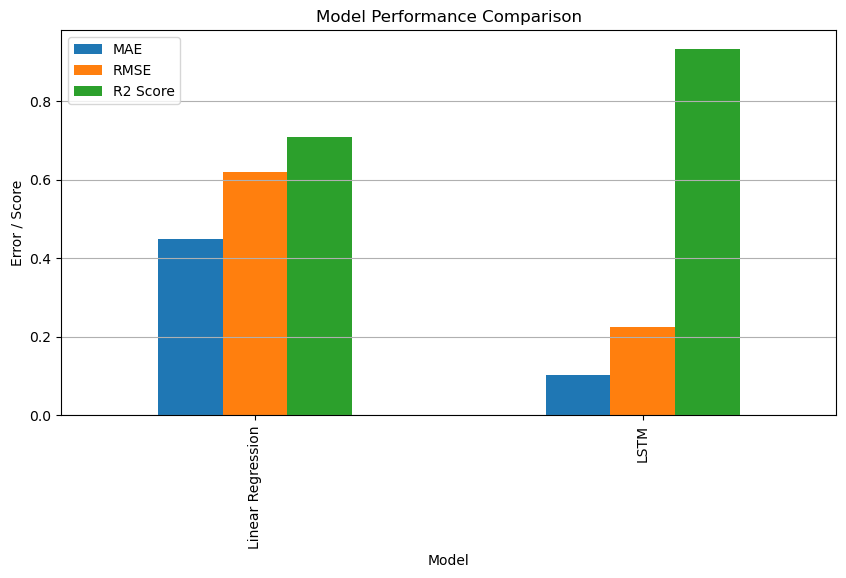

In [19]:
comparison_df.set_index("Model").plot(
    kind="bar",
    figsize=(10,5),
    title="Model Performance Comparison"
)

plt.ylabel("Error / Score")
plt.grid(axis="y")
plt.show()


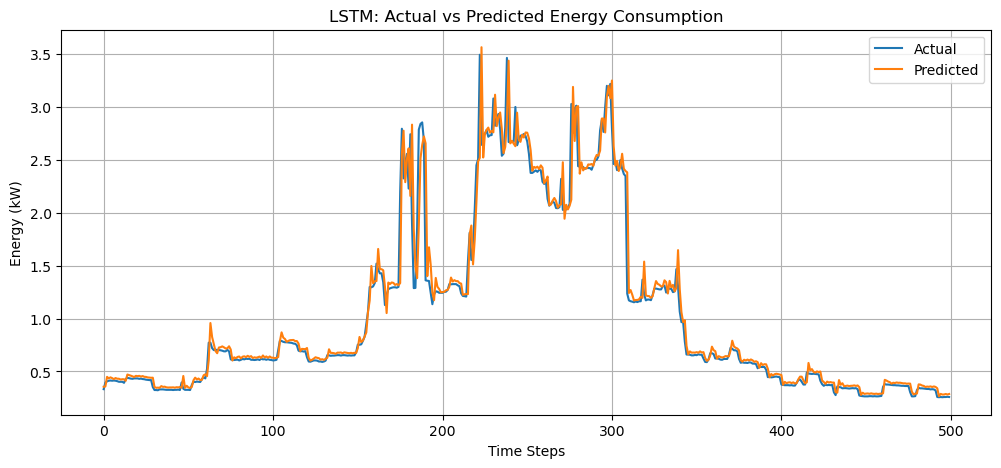

In [14]:
plt.figure(figsize=(12,5))
plt.plot(y_test_actual[:500], label="Actual")
plt.plot(y_pred[:500], label="Predicted")
plt.title("LSTM: Actual vs Predicted Energy Consumption")
plt.xlabel("Time Steps")
plt.ylabel("Energy (kW)")
plt.legend()
plt.grid(True)
plt.show()


In [ ]:
model.save("lstm_energy_model.h5")
joblib.dump(scaler, "energy_scaler.pkl")


['energy_scaler.pkl']

In [16]:
def predict_energy(sequence):
    """
    sequence: last 24 energy values (raw)
    """
    seq_scaled = scaler.transform(np.array(sequence).reshape(-1,1))
    seq_scaled = seq_scaled.reshape(1, WINDOW_SIZE, 1)
    
    prediction_scaled = model.predict(seq_scaled)
    prediction = scaler.inverse_transform(prediction_scaled)
    
    return prediction[0][0]


In [17]:
sample_input = data.values[-24:]
predicted_energy = predict_energy(sample_input)

print("Predicted next hour energy:", predicted_energy)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
Predicted next hour energy: 0.95965415


C:\Users\vinay\AppData\Roaming\Python\Python313\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
